In [1]:
import xarray as xr
import numpy as np
import healpix_geo

import numpy as np
import healpix_geo
from shapely.geometry import Polygon
import geopandas as gpd
from shapely.ops import unary_union, transform

In [2]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union, transform

def get_boundary(cell_ids, level, plot=True):
    lonv, latv = healpix_geo.nested.vertices(cell_ids, depth=level, ellipsoid="WGS84")

    def _unwrap_dateline(lons):
        lons = np.asarray(lons, dtype=float).copy()
        if (np.nanmax(lons) - np.nanmin(lons)) > 180:
            lons[lons < 0] += 360
        return lons

    polys = []
    for i in range(lonv.shape[0]):
        xs = _unwrap_dateline(lonv[i])
        ys = latv[i]
        coords = list(zip(xs, ys))
        if coords[0] != coords[-1]:
            coords.append(coords[0])
        polys.append(Polygon(coords))

    footprint = unary_union(polys)  # Polygon or MultiPolygon

    # Wrap final footprint to [-180, 180] for plotting/overlay with lon=-180..180 data
    footprint_180 = transform(wrap_lon_180, footprint)

    if plot:
        gdf_fp = gpd.GeoDataFrame(
            {"name": ["footprint"]},
            geometry=[footprint_180],
            crs="EPSG:4326",
        )
        ax = gdf_fp.plot(edgecolor="k", facecolor="none", linewidth=2)
        ax.set_aspect("equal")

    return footprint_180
def wrap_lon_180(x, y, z=None):
    x = ((np.asarray(x) + 180) % 360) - 180
    return (x, y) if z is None else (x, y, z)


In [3]:


# Define The ROI bbox in  (lon/lat)
lon_min, lon_max = -2.8, -1.97333
lat_min, lat_max = 47.04367, 47.31558


bbox = (lon_min, lat_min, lon_max, lat_max)

child_level = 13

# Find out child (data projected ) cell_ids 

child_ids, _ , _= healpix_geo.nested.zone_coverage(
    bbox=bbox,
    depth=child_level,
    ellipsoid="WGS84",
    flat=True,  # returns a 1D array of cell ids
)
print(f"N level {child_level} cells covering bbox: {child_ids.size}")


N level 13 cells covering bbox: 3218


In [4]:
# Find out full parent cell id corresponding to the child (data projected ) cell_ids 

parent_level = 10

# 2) Map child ids to parent ids
parent_ids = healpix_geo.nested.zoom_to(
    child_ids,
    depth=child_level,
    new_depth=parent_level,
)
parent_ids, counts = np.unique(parent_ids, return_counts=True)

print(f"N parent level {parent_level} cells: {parent_ids.size}")

N parent level 10 cells: 71


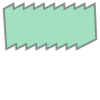

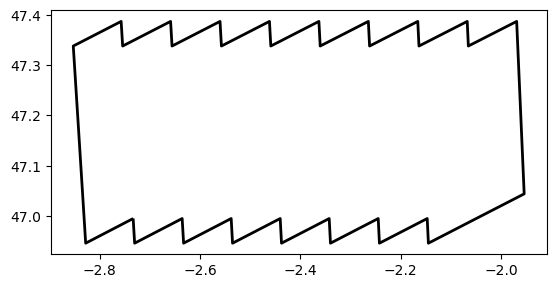

In [5]:
#plot the parent cell ids 
get_boundary(parent_ids,parent_level)
#outer = parent_footprint.boundary 
# Plot

#outer

## we need to create shapely of parent cell id + 2 oufter child cell ids.  2 outer child cell id 
 corresponds to 1 outer cell ids in level= child_level +1 

In [7]:
# translate these parent_cell ids in edge_level. 
edge_level = child_level+1

edges_ids = healpix_geo.nested.zoom_to(
#    boundary_parents_ids,  
     parent_ids,
    depth=parent_level,
    new_depth=edge_level,
)
edges_ids  = np.unique(edges_ids, return_counts=False)


#get_boundary(edges_ids,edge_level)


[897496575 897496831 897496917 ... 903123712 903123968 903124992]


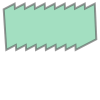

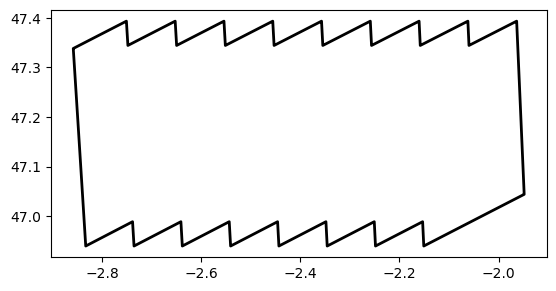

In [8]:
#find N+1 neighbour in edge_level
outer_edges_ids = np.unique(
    healpix_geo.nested.kth_neighbourhood(
        edges_ids,
        edge_level, ring=1, num_threads=0),#return_counts=True
)
print(outer_edges_ids)
outer_boundary=get_boundary(outer_edges_ids,edge_level)
outer_boundary

In [10]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    {"name": ["outer_boundary"]},
    geometry=[outer_boundary],
    crs="EPSG:4326",
)

gdf.to_file("outer_boundary.geojson", driver="GeoJSON")